In [2]:
import torch
from torch import nn # nn contains all PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## Data Preparation

Data can be anything :
* CSV
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio
* DNA
* Text

Machine learning is a game of two parts :

    1. Data to numeric
    2. Build a model to learn pattern of that data

##### Creating data(straingt line) using linear regression formula

`y = a + bX` (a is bias , b is weight)

In [3]:
# Creating *know* parameter
weight = 0.7
bias = 0.3

# Create

start = 0
stop = 1
step = 0.02
X = torch.arange(start, stop, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
device = 'cuda' if torch.cuda.is_available else 'cpu'  # GPU is selected if available else CPU

In [6]:
# Splitting data into training and test set

train_split = int(80 * len(X) / 100)

X_train, y_train = X[:train_split].to(device), y[:train_split].to(device)
X_test, y_test = X[train_split:].to(device), y[train_split:].to(device)

#### Visualizing

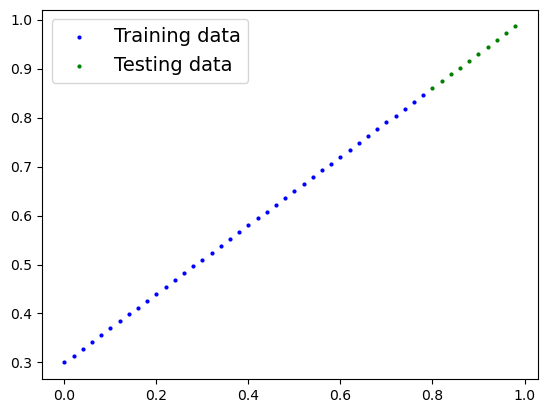

In [284]:
def plot_predictions(y_preds = None):
    plt.scatter(X_train.to('cpu'), y_train.to('cpu'), c = 'blue', s = 4, label = "Training data")
    plt.scatter(X_test.to('cpu'), y_test.to('cpu'), c = 'green', s = 4, label = "Testing data")
        
    if y_preds is not None:
        plt.scatter(X_test.to('cpu'), y_preds.to('cpu'), c = 'red', s = 4, label = "Predictions")
    
    plt.legend(prop = {"size" : 14})
    plt.show()
    
plot_predictions()

### Building a model

* Logistic regression

In [317]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,
                                              requires_grad = True,
                                              dtype = torch.float32))

        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad = True,
                                            dtype = torch.float32))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.weight * x + self.bias # this is the linear regression formula

# OR

In [330]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # defining a layer (layers are much common in deep learning)
        self.linear_layer = nn.Linear(in_features = 1,
                                     out_features = 1)
        
        # forward() defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x should be tensor which returns tensor
        return self.linear_layer(x)

### Pytorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* `torch.optim` - this where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - All nn.Module subclass require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Checking parameters of what's inside our model using `.parameters()`

In [331]:
# setting up random seed
torch.manual_seed(42)

# Creating an object/ instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

model_0.to("cuda") # taking model from CPU to GPU for faster performance

# Checking parameters
list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

In [332]:
# list models parameters.
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [333]:
# Making prediction using `torch.inference_mode()`
# when data is passeed through our model, it's going to run through the forward() methon

with torch.inference_mode():  # use this everytime to have clean predictions and also, in large datasets, predictions are faster.
    y_preds = model_0(X_test)

    
y_preds

tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]], device='cuda:0')

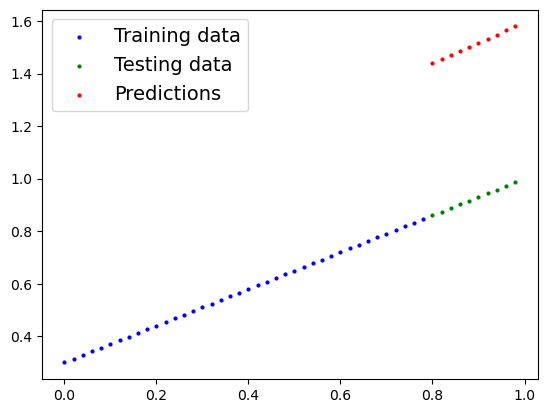

In [334]:
plot_predictions(y_preds)

In [335]:
# Setup a loss function
loss_fn = nn.L1Loss()


# Setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                           lr = 0.001) # Learning rate is the most import hyperparameter. It changes the bias and weights(predictions) value to match the y_test value

### Building a training loop (and a testing loop) in PyTorch

* Loop through the data
* Forward pass (this involves data moving through out model's `forward()` function to make predictions (also called forward propagation)
* Calculate the loss (compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Loss backward - moves backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back propagation**)
* Optimizer step - use optimizer to adjust our model's parameters to try and improve the loss (**gradient(slope) descent**)

In [336]:
torch.manual_seed(42)


# Epoch is the loop through the data
epochs = 2000   # hyperparameter because we set it up ourself

epoch_count = []
train_loss = []
test_loss_values = []


### Training loop
# Loop through the data
for epoch in range(epochs):
    epoch_count.append(epoch)
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients
    
    
    # Forward pass
    y_pred = model_0(X_train)
    
    
    # Calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(f"Loss : {loss}")
    
    train_loss.append(loss)
    
    #  Zero the gradients of the optimizer (they accumulate by default)
    optimizer.zero_grad()
    
    
    # Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    
    # Step the optimizer (perform gradient descent)
    optimizer.step() # by default, optimizer saves the previous value which needs to be reset every the loop runs.
    
    
#     print(model_0.state_dict())





    ### Testing
    # Putting the model in evaluation mode
    model_0.eval() # turns off different settings in the model not needed for evaluations/ testing

    with torch.inference_mode(): # turns off gradient tracking
        
        # Forward pass
        test_preds = model_0(X_test)

        # Calculate the loss
        test_loss = loss_fn(test_preds, y_test)

        test_loss_values.append(test_loss)
        if epoch % 10 == 0:
            print(f"Epoch : {epoch}) | Loss : {loss} | Test loss : {test_loss}")
            print(model_0.state_dict())

   


Loss : 0.5551779866218567
Epoch : 0) | Loss : 0.5551779866218567 | Test loss : 0.5861001014709473
OrderedDict([('linear_layer.weight', tensor([[0.7641]], device='cuda:0')), ('linear_layer.bias', tensor([0.8290], device='cuda:0'))])
Loss : 0.5540258288383484
Loss : 0.5528737902641296
Loss : 0.5517216920852661
Loss : 0.5505696535110474
Loss : 0.5494174957275391
Loss : 0.5482654571533203
Loss : 0.5471133589744568
Loss : 0.545961320400238
Loss : 0.5448092818260193
Loss : 0.5436570644378662
Epoch : 10) | Loss : 0.5436570644378662 | Test loss : 0.5726293921470642
OrderedDict([('linear_layer.weight', tensor([[0.7602]], device='cuda:0')), ('linear_layer.bias', tensor([0.8190], device='cuda:0'))])
Loss : 0.5425050258636475
Loss : 0.5413529276847839
Loss : 0.5402008891105652
Loss : 0.5390487909317017
Loss : 0.5378967523574829
Loss : 0.5367445945739746
Loss : 0.5355924963951111
Loss : 0.5344404578208923
Loss : 0.5332883596420288
Loss : 0.5321362614631653
Epoch : 20) | Loss : 0.5321362614631653 | 

Epoch : 300) | Loss : 0.209552600979805 | Test loss : 0.18197579681873322
OrderedDict([('linear_layer.weight', tensor([[0.6472]], device='cuda:0')), ('linear_layer.bias', tensor([0.5290], device='cuda:0'))])
Loss : 0.20840051770210266
Loss : 0.20724843442440033
Loss : 0.2060963362455368
Loss : 0.20494425296783447
Loss : 0.20379216969013214
Loss : 0.2026400864124298
Loss : 0.20148800313472748
Loss : 0.20033593475818634
Loss : 0.19918383657932281
Loss : 0.19803175330162048
Epoch : 310) | Loss : 0.19803175330162048 | Test loss : 0.168504998087883
OrderedDict([('linear_layer.weight', tensor([[0.6433]], device='cuda:0')), ('linear_layer.bias', tensor([0.5190], device='cuda:0'))])
Loss : 0.19687967002391815
Loss : 0.19572758674621582
Loss : 0.1945754885673523
Loss : 0.19342342019081116
Loss : 0.19227133691310883
Loss : 0.1911192387342453
Loss : 0.18996714055538177
Loss : 0.18881508708000183
Loss : 0.1876629889011383
Loss : 0.18651090562343597
Epoch : 320) | Loss : 0.18651090562343597 | Test 

Epoch : 600) | Loss : 0.019893135875463486 | Test loss : 0.046012092381715775
OrderedDict([('linear_layer.weight', tensor([[0.6014]], device='cuda:0')), ('linear_layer.bias', tensor([0.3418], device='cuda:0'))])
Loss : 0.01985785737633705
Loss : 0.01982256956398487
Loss : 0.019787287339568138
Loss : 0.019752008840441704
Loss : 0.019716722890734673
Loss : 0.019681435078382492
Loss : 0.019646158441901207
Loss : 0.019610870629549026
Loss : 0.019575588405132294
Loss : 0.01954030431807041
Epoch : 610) | Loss : 0.01954030431807041 | Test loss : 0.04559662938117981
OrderedDict([('linear_layer.weight', tensor([[0.6030]], device='cuda:0')), ('linear_layer.bias', tensor([0.3408], device='cuda:0'))])
Loss : 0.01950502023100853
Loss : 0.019470898434519768
Loss : 0.01943611167371273
Loss : 0.019402379170060158
Loss : 0.01936747319996357
Loss : 0.01933358795940876
Loss : 0.01929895207285881
Loss : 0.01926468312740326
Loss : 0.019230423495173454
Loss : 0.01919577270746231
Epoch : 620) | Loss : 0.0191

OrderedDict([('linear_layer.weight', tensor([[0.6303]], device='cuda:0')), ('linear_layer.bias', tensor([0.3293], device='cuda:0'))])
Loss : 0.01400972343981266
Loss : 0.013975574634969234
Loss : 0.013941192999482155
Loss : 0.013906669802963734
Loss : 0.013872668147087097
Loss : 0.013837769627571106
Loss : 0.013804142363369465
Loss : 0.013769241981208324
Loss : 0.013735241256654263
Loss : 0.013700718060135841
Epoch : 780) | Loss : 0.013700718060135841 | Test loss : 0.03194333240389824
OrderedDict([('linear_layer.weight', tensor([[0.6320]], device='cuda:0')), ('linear_layer.bias', tensor([0.3286], device='cuda:0'))])
Loss : 0.013666331768035889
Loss : 0.01363219041377306
Loss : 0.013597428798675537
Loss : 0.013563665561378002
Loss : 0.013528767041862011
Loss : 0.013494900427758694
Loss : 0.013460241258144379
Loss : 0.013425997458398342
Loss : 0.013391715474426746
Loss : 0.013357087038457394
Epoch : 790) | Loss : 0.013357087038457394 | Test loss : 0.03118462674319744
OrderedDict([('linea

Loss : 0.00803395826369524
Loss : 0.007999081164598465
Loss : 0.00796543713659048
Loss : 0.007930533960461617
Loss : 0.00789655465632677
Loss : 0.007862008176743984
Epoch : 950) | Loss : 0.007862008176743984 | Test loss : 0.01829003170132637
OrderedDict([('linear_layer.weight', tensor([[0.6611]], device='cuda:0')), ('linear_layer.bias', tensor([0.3164], device='cuda:0'))])
Loss : 0.00782765168696642
Loss : 0.007793480064719915
Loss : 0.007758742664009333
Loss : 0.0077249594032764435
Loss : 0.007690049707889557
Loss : 0.007656219881027937
Loss : 0.0076215253211557865
Loss : 0.0075873094610869884
Loss : 0.007553005125373602
Loss : 0.007518403232097626
Epoch : 960) | Loss : 0.007518403232097626 | Test loss : 0.01753133535385132
OrderedDict([('linear_layer.weight', tensor([[0.6628]], device='cuda:0')), ('linear_layer.bias', tensor([0.3156], device='cuda:0'))])
Loss : 0.007484478410333395
Loss : 0.0074495780281722546
Loss : 0.007415881846100092
Loss : 0.007381049450486898
Loss : 0.007346972

Loss : 0.0022980363573879004
Loss : 0.002263755304738879
Loss : 0.0022295124363154173
Loss : 0.0021948516368865967
Loss : 0.002160987351089716
Loss : 0.002126080682501197
Loss : 0.0020923272240906954
Loss : 0.0020575590897351503
Loss : 0.002023416105657816
Epoch : 1120) | Loss : 0.002023416105657816 | Test loss : 0.00467108516022563
OrderedDict([('linear_layer.weight', tensor([[0.6901]], device='cuda:0')), ('linear_layer.bias', tensor([0.3041], device='cuda:0'))])
Loss : 0.001989036099985242
Loss : 0.0019545124378055334
Loss : 0.0019205078715458512
Loss : 0.0018856056267395616
Loss : 0.0018513434333726764
Loss : 0.001817526645027101
Loss : 0.0017828196287155151
Loss : 0.0017486222786828876
Loss : 0.0017142922151833773
Loss : 0.001679719309322536
Epoch : 1130) | Loss : 0.001679719309322536 | Test loss : 0.0038780630566179752
OrderedDict([('linear_layer.weight', tensor([[0.6918]], device='cuda:0')), ('linear_layer.bias', tensor([0.3034], device='cuda:0'))])
Loss : 0.001645768410526216
Lo

Loss : 0.0007765308255329728
Epoch : 1290) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1300) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.000375553965

Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1470) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1480) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.000375553965

Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1660) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1670) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.000375553965

Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1840) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Epoch : 1850) | Loss : 0.0007765308255329728 | Test loss : 0.000619995582383126
OrderedDict([('linear_layer.weight', tensor([[0.6995]], device='cuda:0')), ('linear_layer.bias', tensor([0.2998], device='cuda:0'))])
Loss : 0.0003755539655685425
Loss : 0.0007765308255329728
Loss : 0.000375553965

In [337]:
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3008], device='cuda:0'))])

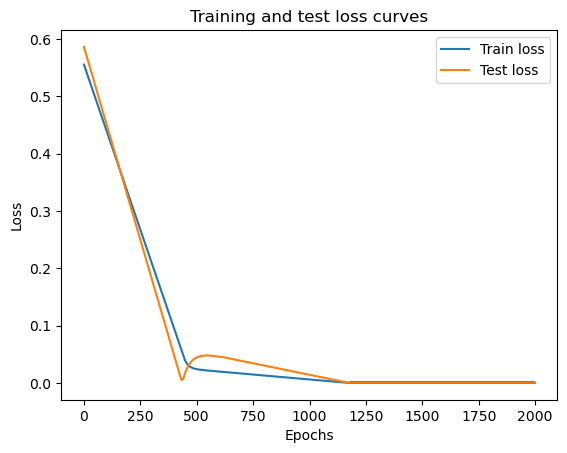

In [338]:
plt.plot(epoch_count, np.array(torch.tensor(train_loss).cpu().numpy()), label = "Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu(), label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

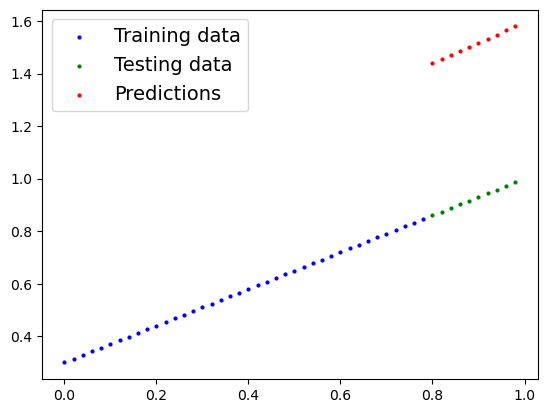

In [339]:
plot_predictions(y_preds)

### Inorder to have more accurate result, Learning rate and epochs can be changed.

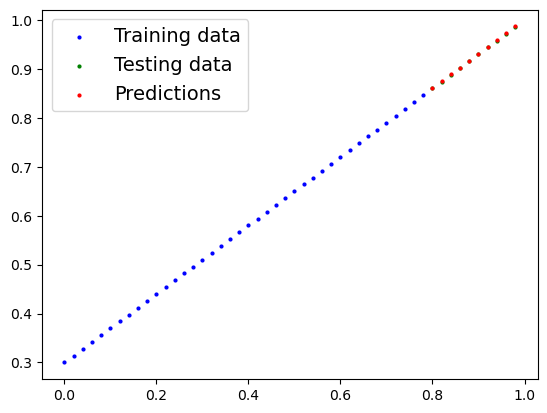

In [340]:
plot_predictions(test_preds)

### Saving and Loading a model

There are three main methods.

1. `torch.save()` - saves the model in pickle format
2. `torch.load()` - loads the saved PyTorch object/model
3. `torch.nn.Module.load_state_dict()` - loads a model's saved state dictionary

In [237]:
from pathlib import Path

# Create Models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True) # if already exists, wont throw error

# Create Model save path
MODEL_NAME = "basic_neural_netork_model(state_dict()).pth"
MODEL_SAVE_PATH_State_dict = MODEL_PATH / MODEL_NAME

# Save Model State_dict()
print(f"Saving model state_dict() to : {MODEL_SAVE_PATH_State_dict}")
torch.save(obj = model_0.state_dict(),
          f = MODEL_SAVE_PATH_State_dict)



Saving model state_dict() to : models\basic_neural_netork_model(state_dict()).pth


In [238]:
# Create Models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True) # if already exists, wont throw error

# Create Model save path
FULL_MODEL_NAME = "basic_neural_netork_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / FULL_MODEL_NAME


# Save entire Model
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = model_0,
          f = MODEL_SAVE_PATH)


Saving model to : models\basic_neural_netork_model.pth


In [239]:
# instanciate a model
new_model = LinearRegressionModel()

# load saved dict to new model
new_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH_State_dict))


<All keys matched successfully>

In [240]:
new_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]])),
             ('linear_layer.bias', tensor([0.3008]))])

In [241]:
# Making predictions using new model
new_model.eval()
with torch.inference_mode():
    new_model_preds = new_model(X_test)

#### Similarly, full model can be loaded as well. Here, only the parameters of the saved model is passed to this model

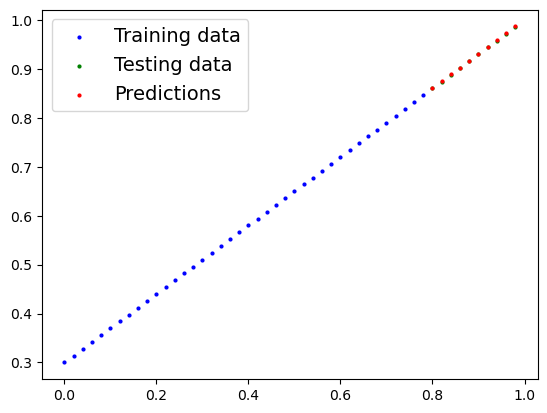

In [242]:
plot_predictions(new_model_preds)

In [243]:
test_preds == new_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [314]:
torch.tensor(test_loss_values).unsqueeze(dim = 1).cpu()

tensor([[0.0007],
        [0.0006],
        [0.0007],
        ...,
        [0.0006],
        [0.0007],
        [0.0006]])